In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_recall_fscore_support as prfs
from torch.utils.data import Dataset
import natsort
from PIL import Image
plt.ion()

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation*?<>
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

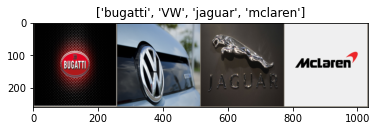

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

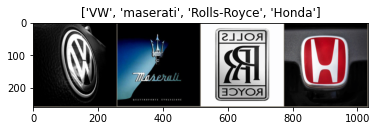

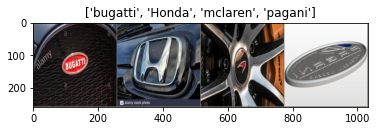

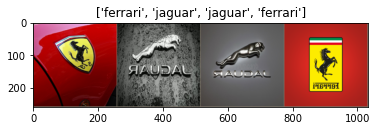

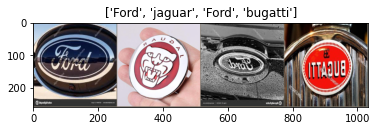

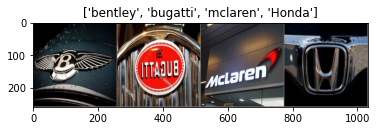

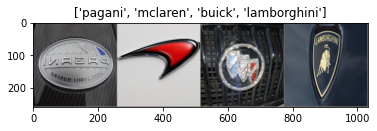

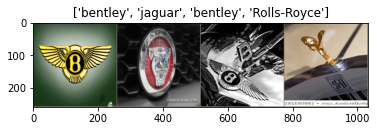

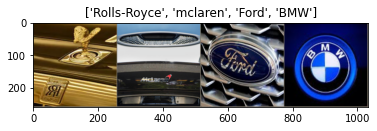

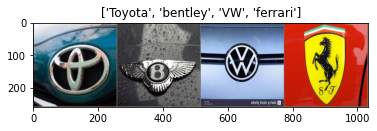

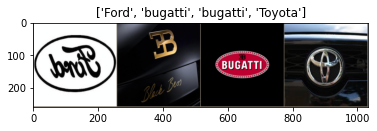

In [4]:
for i in range(10):
    inputs, classes = next(iter(dataloaders['train']))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_lst = []
    train_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "train":
                train_loss_lst.append(epoch_loss)
                train_acc_lst.append(epoch_acc)
            elif phase == 'val':
                val_loss_lst.append(epoch_loss)
                val_acc_lst.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))
    ax0.set_title('Loss')
    ax0.plot(range(len(train_loss_lst)), train_loss_lst, 'o-', label = 'train')
    ax0.plot(range(len(val_loss_lst)), val_loss_lst, 'o-', label = 'val')
    ax0.legend()
    ax0.set_xlabel('epoch #')

    ax1.set_title('Accuracy')
    ax1.plot(range(len(train_acc_lst)),  train_acc_lst, 'o-', label = 'train')
    ax1.plot(range(len(val_acc_lst)),  val_acc_lst, 'o-', label = 'val')
    ax1.legend()
    ax1.set_xlabel('epoch #')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        

In [6]:
def success_metrics(model):
    model.eval()
    original_labels = []
    pred_lst = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            original_labels.extend(labels)
            pred_lst.extend(preds)
            
    precision, recall, f1, support = prfs(original_labels, pred_lst, average='weighted')

    print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}".format(precision, recall, f1))

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 16)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Epoch 0/19
----------
train Loss: 2.0052 Acc: 0.4236
val Loss: 0.4746 Acc: 0.8696

Epoch 1/19
----------
train Loss: 0.7153 Acc: 0.8310
val Loss: 0.1533 Acc: 0.9565

Epoch 2/19
----------
train Loss: 0.3437 Acc: 0.9329
val Loss: 0.1158 Acc: 0.9478

Epoch 3/19
----------
train Loss: 0.2560 Acc: 0.9421
val Loss: 0.0914 Acc: 0.9739

Epoch 4/19
----------
train Loss: 0.1882 Acc: 0.9745
val Loss: 0.0605 Acc: 0.9826

Epoch 5/19
----------
train Loss: 0.1482 Acc: 0.9676
val Loss: 0.0627 Acc: 0.9826

Epoch 6/19
----------
train Loss: 0.1551 Acc: 0.9676
val Loss: 0.0445 Acc: 0.9913

Epoch 7/19
----------
train Loss: 0.0821 Acc: 0.9884
val Loss: 0.0440 Acc: 0.9826

Epoch 8/19
----------
train Loss: 0.0809 Acc: 0.9861
val Loss: 0.0452 Acc: 0.9913

Epoch 9/19
----------
train Loss: 0.0800 Acc: 0.9931
val Loss: 0.0423 Acc: 0.9826

Epoch 10/19
----------
train Loss: 0.0567 Acc: 1.0000
val Loss: 0.0511 Acc: 0.9826

Epoch 11/19
----------
train Loss: 0.0959 Acc: 0.9861
val Loss: 0.0339 Acc: 0.9913

Ep

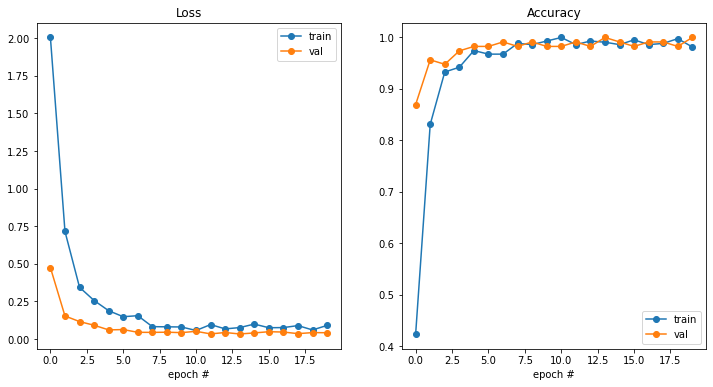

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,  num_epochs=20)

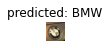

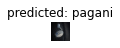

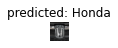

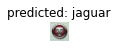

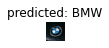

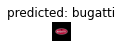

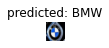

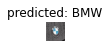

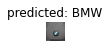

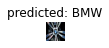

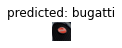

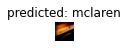

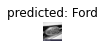

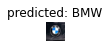

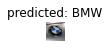

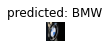

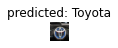

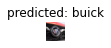

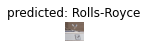

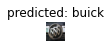

In [10]:
visualize_model(model_ft, num_images=20)

In [9]:
success_metrics(model_ft)

Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


In [11]:
torch.save(model_ft, "./tlmodelv3.1")

### Put the model into use: predict a picture with car logo assuming unknowning the brand

In [33]:
model = torch.load("./tlmodelv3.1")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

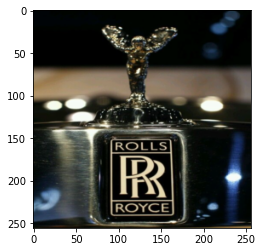

['BMW', 'Ford', 'Honda', 'Rolls-Royce', 'Toyota', 'VW', 'bentley', 'bugatti', 'buick', 'ferrari', 'jaguar', 'koenigsegg', 'lamborghini', 'maserati', 'mclaren', 'pagani']
tensor([6.6935e-07, 6.0868e-06, 3.7402e-07, 9.9998e-01, 5.3206e-07, 4.3650e-07,
        2.6237e-07, 4.0976e-07, 1.5176e-07, 5.2689e-07, 1.7333e-07, 3.7882e-07,
        6.7449e-06, 2.4097e-07, 4.5557e-07, 8.1404e-07],
       grad_fn=<SelectBackward>)
This image most likely belongs to Rolls-Royce with a 100.00 percent confidence.


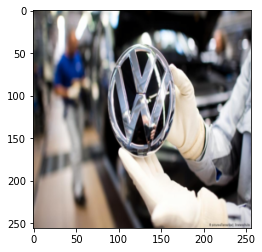

['BMW', 'Ford', 'Honda', 'Rolls-Royce', 'Toyota', 'VW', 'bentley', 'bugatti', 'buick', 'ferrari', 'jaguar', 'koenigsegg', 'lamborghini', 'maserati', 'mclaren', 'pagani']
tensor([3.9364e-03, 4.7825e-04, 6.5573e-05, 1.7025e-03, 1.7484e-02, 6.3693e-01,
        2.8148e-03, 3.1798e-04, 2.3483e-01, 7.1182e-04, 6.4218e-02, 2.9096e-03,
        1.8189e-04, 3.1672e-02, 1.0755e-03, 6.6649e-04],
       grad_fn=<SelectBackward>)
This image most likely belongs to VW with a 63.69 percent confidence.


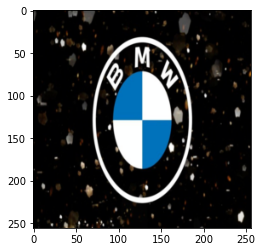

['BMW', 'Ford', 'Honda', 'Rolls-Royce', 'Toyota', 'VW', 'bentley', 'bugatti', 'buick', 'ferrari', 'jaguar', 'koenigsegg', 'lamborghini', 'maserati', 'mclaren', 'pagani']
tensor([9.9951e-01, 1.0084e-06, 1.3900e-04, 4.2497e-06, 4.4216e-06, 7.7554e-05,
        4.1988e-06, 5.3906e-05, 5.9252e-06, 4.6531e-06, 1.4280e-04, 2.9872e-06,
        1.5120e-05, 2.0686e-05, 6.5835e-06, 8.2285e-06],
       grad_fn=<SelectBackward>)
This image most likely belongs to BMW with a 99.95 percent confidence.


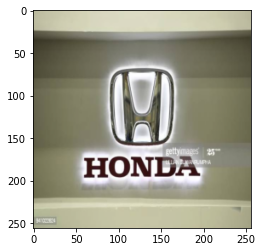

['BMW', 'Ford', 'Honda', 'Rolls-Royce', 'Toyota', 'VW', 'bentley', 'bugatti', 'buick', 'ferrari', 'jaguar', 'koenigsegg', 'lamborghini', 'maserati', 'mclaren', 'pagani']
tensor([1.4800e-03, 1.1240e-04, 9.7802e-01, 1.7946e-03, 1.1271e-03, 5.0464e-04,
        1.2831e-03, 7.1951e-04, 1.3560e-04, 1.3647e-04, 7.8557e-04, 4.3286e-04,
        4.9725e-03, 8.1306e-04, 7.2419e-03, 4.4319e-04],
       grad_fn=<SelectBackward>)
This image most likely belongs to Honda with a 97.80 percent confidence.


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open("class_names.txt", 'r') as f:
    class_names = [line.rstrip('\n') for line in f]
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
def predict_unknown_sample2(model, loc = './unknown'):
    data_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    unknown_img = CustomDataSet("./unknown", transform=data_transforms)
    loaded_img = torch.utils.data.DataLoader(unknown_img, batch_size = 1)
    model.eval()
    original_labels = []
    pred_lst = []
    for i, inputs in enumerate(loaded_img):
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        prob = nn.functional.softmax(outputs, 1)

        pred_lst.extend(preds)
        imshow(inputs.cpu().data[0])
        print(class_names)
        print(prob[0])
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[preds[0]], 100 * np.max(prob.cpu().detach().numpy()[0]))
        )
    
if __name__ == '__main__':
     predict_unknown_sample2(model, loc = './unknown')

In [29]:
import pandas as pd
pd.DataFrame(class_names).to_csv("class_names.txt",index=False,header=False, )